In [1]:
import numpy as np
from scipy.sparse.linalg import expm
from numpy import random, zeros, sqrt,cos,sin
import numbers
from numpy import sqrt, zeros, diag, random, real, array, complex_, transpose, conjugate, exp, matmul,imag,conj,zeros,sum,concatenate
from scipy.linalg import norm
from numpy import dot,array
from numpy import pi as pi
import scipy
from scipy import sparse
import scipy.sparse as sp
from scipy.sparse import csr_matrix, kron, coo_matrix, identity
from numpy import dot,add
from numpy.random import choice, normal
import pandas as pd
import functools as ft
from functools import reduce
from scipy.integrate import solve_ivp



S_spin=3   #determine the number of Zeeman levels (2S+1)

#Parameters  (Check the units)

B_Q=-1.85 # in Vdd units
N_atom=192
Levels=int(2*S_spin+1)
Atom_cutoff=5
max_step=0.005

Random_signature=np.random.rand(1,1)[0,0].round(6)


# In[41]:


tspan=np.linspace(0,2,50)

#Array Vij will be provided by Sean, just we will play with a random Vij for testing that the code makes sense.
#Mgen=np.random.rand(N_atom,N_atom)


Vij_p=array(pd.read_csv('Vij.csv', header=None))


# In[5]:



# In[6]:


Vij=(Vij_p-np.diag(np.diag(Vij_p)))


# In[7]:


VijN=np.zeros((N_atom,N_atom))

for j in range(N_atom):
    
    VijN[j]=Vij[j][:N_atom]
    
    
 

# In[8]:


Vij=VijN


# In[ ]:





# In[9]:



def index_Gij(arr,Atom_cutoff):
    
    Ordered_N = list(np.argsort(arr)[::-1][:Atom_cutoff])
    
    return Ordered_N

# Provides a list of lists with the arrays that belong to each cluster


Index_N=[]

Rem_iden=abs(Vij)


for j in range(Rem_iden.shape[0]):
    
    test_list = list(Rem_iden[j])
    
    Index_N.append( [j]+list(index_Gij(test_list,Atom_cutoff-1))  )


# In[ ]:





# In[10]:


def RedVij(list_index,Atom_cutoff=Atom_cutoff):
    
    Vijred=np.zeros((Atom_cutoff,Atom_cutoff))
    
    Iterator_list=Index_N[list_index]
    
    for i in range(Atom_cutoff):
        for j in range(Atom_cutoff):
            
            Vijred[i,j]=Vij[Iterator_list[i],Iterator_list[j]]
            
            
    
    
    return Vijred


# In[11]:


VijredAv=np.zeros((Atom_cutoff,Atom_cutoff))

Vij_red_cuad=np.zeros((Atom_cutoff,Atom_cutoff))



for j in range(N_atom):
    
    VijredAv=VijredAv+RedVij(j)
    
    Vij_red_cuad=Vij_red_cuad+(RedVij(j))**2
    
VijredAv=VijredAv/N_atom  

In [2]:
Standard_dev=sqrt(((Vij_red_cuad-N_atom*(VijredAv)**2)/(N_atom-1)).round(10)).round(4)

In [3]:
Standard_dev

array([[0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.0722, 0.0722],
       [0.    , 0.    , 0.    , 0.0722, 0.0722],
       [0.    , 0.0722, 0.0722, 0.    , 0.    ],
       [0.    , 0.0722, 0.0722, 0.    , 0.    ]])

In [4]:
VijredAv

array([[ 0.        , -1.17265067, -1.17265067,  0.97780472,  0.97780472],
       [-1.17265067,  0.        , -0.14658133, -0.1597394 , -0.15071865],
       [-1.17265067, -0.14658133,  0.        , -0.15071865, -0.1597394 ],
       [ 0.97780472, -0.1597394 , -0.15071865,  0.        ,  0.12222559],
       [ 0.97780472, -0.15071865, -0.1597394 ,  0.12222559,  0.        ]])

In [5]:
TriU_dev=np.triu(Standard_dev)


In [11]:
# In[ ]:

# In[12]:



Vijsumfc=np.zeros((N_atom,N_atom))
    

for i in range(N_atom):
    Viabs=( RedVij(i) )
    
    
    
    for j in range(N_atom):
        Vjabs=( RedVij(j))
        
        Vvij=Viabs-Vjabs
        
        T1=Vvij[  0]
        T2=Vvij[:,0]
        
        
        Vijsumfc[i,j]=sum(abs(T1))+sum(abs(T2))
            
            
    
    


Val=np.linspace(-S_spin,S_spin,int(2*S_spin+1))
Coord=np.linspace(0,2*S_spin,int(2*S_spin+1))
    
Sz_sp=sparse.coo_matrix((Val,(Coord,Coord)),shape=(int(2*S_spin+1),int(2*S_spin+1)),dtype="complex") 


# In[15]:


#Define Splus

Val=[]


for j in range(1,int(2*S_spin)+1):
    
    Val.append(sqrt((S_spin)*(S_spin+1)-(S_spin-j)*(S_spin+1-j)))
    

Coord=np.linspace(0,int(2*S_spin)-1,int(2*S_spin))    
Splu_sp=(sparse.coo_matrix((Val,(Coord,Coord+1)),shape=(int(2*S_spin)+1,int(2*S_spin)+1),dtype="complex")) 

Sx_sp=(Splu_sp+Splu_sp.T)/2
Sy_sp=(Splu_sp-Splu_sp.T)/(2j)


# In[ ]:





# In[16]:


#Initial state |S,-S>
Init_st=(sparse.coo_matrix(([1],([Levels-1],[0])),shape=(int(2*S_spin)+1,1),dtype="complex")) 

#Rotated initial state

Init_st_rot=(expm(scipy.sparse.csc_matrix(-1j*(np.pi/2)*Sy_sp))@Init_st)


# In[17]:


Id_Spin=scipy.sparse.identity(Levels, dtype='complex')

Zero_Spin=0*Id_Spin


def Zeeman_Popul(m_s):
    
    return sparse.coo_matrix(([1],([S_spin-m_s],[S_spin-m_s])),shape=(Levels,Levels),dtype="complex")


# In[18]:


Init_st_rot.toarray()


# In[ ]:





# In[19]:


Init_st_rot


# In[20]:


Init_Total_rot=Init_st_rot

for j in range(Atom_cutoff-1):
    
    Init_Total_rot=kron(Init_Total_rot,Init_st_rot)
    


# In[21]:


Init_Total_rot=coo_matrix(Init_Total_rot)  #Initial state wavefunction


# In[22]:


Init_Total_rot


# In[ ]:





# In[23]:



def tensor_id(ArrayL ):
    
    Tensor_id=kron(ArrayL[0],ArrayL[1])
    
    Array_id=Atom_cutoff*[Id_Spin]    
    
    for j in range(2,len(ArrayL)):
        
        Tensor_id=kron(Tensor_id,Array_id[j])
        
    
    #return coo_matrix(Tensor_id.todense())
    return coo_matrix(Tensor_id)


# In[ ]:





# In[24]:


Iden_Tensor=coo_matrix(identity((Levels)**Atom_cutoff, dtype='complex'))
Zero_Tensor=0*Iden_Tensor


# In[25]:



lst = Atom_cutoff*[Id_Spin]
XX = reduce(kron, lst)


# In[ ]:





def A_i_tensor(A_op,i_index):
    
    Array_id=Atom_cutoff*[Id_Spin] 
    
    Array_id[i_index]=A_op
    
    return reduce(kron, Array_id)


def tensor_kjXYZ2( k , j):   #tensor among k,j are Positions in the cluster after the G classification
                         #k is +sigma and j is -sigma
        
    Array_idX   = Atom_cutoff*[Id_Spin]   
    Array_idX[k]= Sx_sp
    Array_idX[j]= Sx_sp
    
    Array_idY   = Atom_cutoff*[Id_Spin]
    Array_idY[k]= Sy_sp
    Array_idY[j]= Sy_sp
    
    Array_idZ   = Atom_cutoff*[Id_Spin]
    Array_idZ[k]= Sz_sp
    Array_idZ[j]= Sz_sp

    return reduce(kron, Array_idX),reduce(kron, Array_idY),reduce(kron, Array_idZ) 


# In[ ]:





# In[29]:


def tensor_termIntact( k , j):   #tensor among k,j are Positions in the cluster after the G classification
                         #k is +sigma and j is -sigma
        
    Array_idX   = Atom_cutoff*[Id_Spin]   
    Array_idX[k]= Sx_sp
    Array_idX[j]= Sx_sp
    
    Array_idY   = Atom_cutoff*[Id_Spin]
    Array_idY[k]= Sy_sp
    Array_idY[j]= Sy_sp
    
    Array_idZ   = Atom_cutoff*[Id_Spin]
    Array_idZ[k]= Sz_sp
    Array_idZ[j]= Sz_sp

    return reduce(kron, Array_idZ)-0.5*( reduce(kron, Array_idX)+reduce(kron, Array_idY) ) 


# In[ ]:





# In[ ]:





# In[30]:


def tensor_kjXX( k , j):   #tensor among k,j are Positions in the cluster after the G classification
                         #k is +sigma and j is -sigma 
    Array_id=Atom_cutoff*[Id_Spin]  
    
    Array_id[k]=Sx_sp
    Array_id[j]=Sx_sp

    return reduce(kron, Array_id)


# In[31]:


def tensor_kjYY( k , j):   #tensor among k,j are Positions in the cluster after the G classification
                         #k is +sigma and j is -sigma 
    Array_id=Atom_cutoff*[Id_Spin]  
    
    Array_id[k]=Sy_sp
    Array_id[j]=Sy_sp

    return reduce(kron, Array_id)


# In[32]:


def tensor_kjZZ( k , j):   #tensor among k,j are Positions in the cluster after the G classification
                         #k is +sigma and j is -sigma 
    Array_id=Atom_cutoff*[Id_Spin]  
    
    Array_id[k]=Sz_sp
    Array_id[j]=Sz_sp

    return reduce(kron, Array_id)


# In[33]:


Sz_cuad=Sz_sp@Sz_sp


# In[34]:


def tensor_k_Zcuad( k ):  #Excited state k is a Position in the cluster after the G classification
    
    Array_id=Atom_cutoff*[Id_Spin]  
    
    Array_id[k]=Sz_cuad
        
    return reduce(kron, Array_id)


# In[ ]:





# In[35]:


# Construct a vector with |C_i| elements equal to A_i_tensor(Sz_cuad,j)

Sz_cuad_array=Zero_Tensor


for j in range(Atom_cutoff):
    
    Sz_cuad_array+= B_Q* A_i_tensor(Sz_cuad,j)
    


# In[ ]:





# In[36]:



def Hamilt_ic_Red(VijNew=VijredAv):
     
    Hamil=Sz_cuad_array
    
    
    for j in range(Atom_cutoff):
        
        for k in range(j+1,Atom_cutoff):
            

            Ten_jk = tensor_termIntact( j , k)

            
            Hamil=Hamil+ VijNew[j,k]*Ten_jk
            
            #print(j,k,"IndexN", IL_j,IL_k)
            

    return  Hamil


# In[ ]:





# In[37]:



def Hamilt_ic(index_center,):
     
    Index_list=Index_N[index_center]
    Hamil=Sz_cuad_array
    
    
    for j in range(Atom_cutoff):
        
        IL_j   = Index_list[j]
        
        for k in range(j+1,Atom_cutoff):
            
            
            IL_k   = Index_list[k]

            Ten_jk = tensor_termIntact( j , k)

            
            Hamil=Hamil+ Vij[IL_j,IL_k]*Ten_jk
            
            #print(j,k,"IndexN", IL_j,IL_k)
            

    return  Hamil


# In[38]:



def f(t, yR,M_vect,b):

    return -1j*M_vect@yR


# In[39]:




Zeeman_Operators=[]


for j in range(-S_spin,S_spin+1):
    
    Zeeman_Operators.append(A_i_tensor(Zeeman_Popul( -j),0))
    







# In[42]:



index_center=1


# In[ ]:





# In[43]:


T_init=tspan[0]

T_fin =tspan[-1]






def Dynam_Popul_CI():
    
    Normal_Sample=np.random.normal(0, 1, size=(Atom_cutoff, Atom_cutoff))
    VijNewK=VijredAv+ (TriU_dev*Normal_Sample+(TriU_dev*Normal_Sample).T)

    
    Populations=np.zeros((Levels,len(tspan)))
    
    #
    #Hamilt_ic(index_center)
    

    sol = solve_ivp(f, [tspan[0], tspan[-1]], list(Init_Total_rot.toarray().T[0]),args=(Hamilt_ic_Red(VijNewK),None),dense_output=True,max_step=max_step )
    #sol = solve_ivp(f, [T_init, T_fin], list(Init_Total_rot.toarray().T[0]),args=(Hamilt_ic_CMFT(index_center,Vj_dot_MV_XYZ,Mean_Val_XYZ),None),dense_output=True,max_step=0.001 )

    Sol_dense=sol.sol(tspan)
    
    
    for j in range(Levels):
        
        Populations[j]=real((diag((conj(Sol_dense.T)@(Zeeman_Operators[j]@Sol_dense)))))
        
        
    VarL=(3**2)*Populations[0]
    VarL=VarL+(2**2)*Populations[1]
    VarL=VarL+(1**2)*Populations[2]
    VarL=VarL+(0**2)*Populations[3]
    VarL=VarL+((-1)**2)*Populations[4]
    VarL=VarL+((-2)**2)*Populations[5]
    VarL=VarL+((-3)**2)*Populations[6]
        
        
    return VarL,Populations

  
    
    

In [12]:
ResultStSt=Dynam_Popul_CI()

In [17]:


import matplotlib.pyplot as plt
import numpy as np
#from google.colab import files

"""In order to provide a better presentation of the graphs we use the rcParams options shown below."""

import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)

from numpy import cos, sin

label_size = 20

from numpy import sqrt

import time
from numba import jit
from numpy import sin, cos

T0=time.time()

from numpy import conjugate as conj

from numpy import zeros

from numpy import exp

import scipy

from numpy import diff
from numpy.random import randint

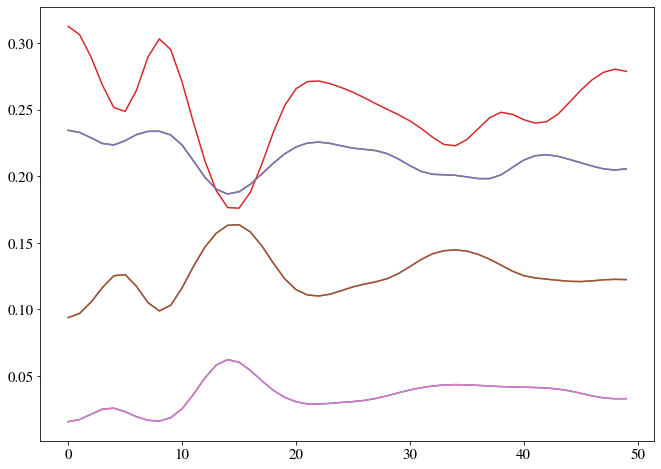

In [18]:
plt.plot(ResultStSt[1][0])
plt.plot(ResultStSt[1][1])
plt.plot(ResultStSt[1][2])
plt.plot(ResultStSt[1][3])
plt.plot(ResultStSt[1][4])
plt.plot(ResultStSt[1][5])
plt.plot(ResultStSt[1][6])

In [8]:
ResultSt3=ResultStSt

In [10]:
ResultSt3

array([1.5       , 1.55032795, 1.68037381, 1.82806523, 1.91120946,
       1.8799329 , 1.75658093, 1.62096387, 1.56122259, 1.63204773,
       1.83613317, 2.12652575, 2.42547094, 2.65334462, 2.75649843,
       2.72251651, 2.57831751, 2.37516112, 2.16838029, 1.99965992,
       1.88871852, 1.83552586, 1.82682177, 1.84293144, 1.86599663,
       1.88738635, 1.90945755, 1.94071455, 1.9883181 , 2.0527905 ,
       2.12732634, 2.20144737, 2.26588526, 2.31504254, 2.34659415,
       2.36063467, 2.35909574, 2.34447052, 2.31911233, 2.28623654,
       2.24988342, 2.2126274 , 2.17418684, 2.13278123, 2.08820478,
       2.04375625, 2.0049501 , 1.97622227, 1.95876106, 1.95163582])

In [9]:
import matplotlib.pyplot as plt

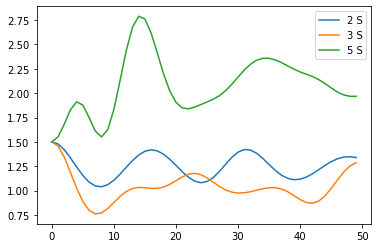

In [54]:

plt.plot(ResultSt2,label="2 S")

plt.plot(ResultSt3,label="3 S")

#plt.plot(Result4S,label="4 S")

plt.plot(ResultSt5 ,label= "5 S")


plt.legend()

In [ ]:
Standard_dev

In [73]:


#VarL0dot1=VarL
VarL0dot001=VarL


# In[ ]:





# In[50]:


Shape=VarL0dot001.shape[0]


# In[51]:


VarL0dot001=VarL0dot001.reshape(Shape,1)


# In[52]:


tspan=tspan.reshape(Shape,1)


# In[ ]:

  



# In[56]:



Res_conc=np.concatenate((tspan,VarL0dot001),axis=1)
Res_conc=np.concatenate((Res_conc[0].reshape(1,len(Res_conc[0])),Res_conc),axis=0)


# In[57]:




# In[58]:


file = open("_MACE_AV__N_atom_"+str(N_atom)+"_Cluster_size_"+str(Atom_cutoff)+"_Max_step_"+str(max_step)+"_Tspan_"+str(tspan[0,0])+"-"+str(tspan[-1,0])+"_Signature_"+str(Random_signature)+".txt", "w+")
np.savetxt(file, Res_conc, delimiter=',')
file.write('\n')
file.write('\n')
file.close()   


#import pandas as pd
#Res0128_1dot25_0=np.array(pd.read_csv('_MACE_AV__N_atom192_Cluster_size_4_Max_step_0.001_Tspan_0.0-2.0_Signature_0.520019.txt')).astype(complex)


# In[ ]:

KeyboardInterrupt: 